<a href="https://colab.research.google.com/github/MohammadAli-Balaj/DCGAN/blob/main/DCGAN_Human_Final_Version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mohammad Ali Balaj
## Artificial Neural Networks and Deep Learning II
### DCGANs for generating human faces 
#### Using Adam optimizer with 0.0001 learning rate, 8001 epochs and 256 as batch size

# GPU information:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 28 01:47:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Importing data:

In [ ]:
from google.colab import drive
drive.mount('data',force_remount=True)

Mounted at data


In [ ]:
basePath='/content/data/MyDrive/Colab Notebooks/Humans'

# Needed libraries:

In [ ]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')
import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose
from tensorflow.compat.v1.keras.layers import BatchNormalization

# Reading the data:

In [ ]:
def list_images(basePath, contains=None):
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

In [ ]:
def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        
        for filename in filenames:
            if contains is not None and filename.find(contains) == -1:
                continue

            ext = filename[filename.rfind("."):].lower()

            if ext.endswith(validExts):
                imagePath = os.path.join(rootDir, filename)
                yield imagePath
                

In [ ]:
def load_images(directory='', size=(64,64)):
    images = []
    labels = []
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) 
            image = cv2.resize(image,size) 

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [ ]:
images=load_images(basePath)

# Visualizing samples:

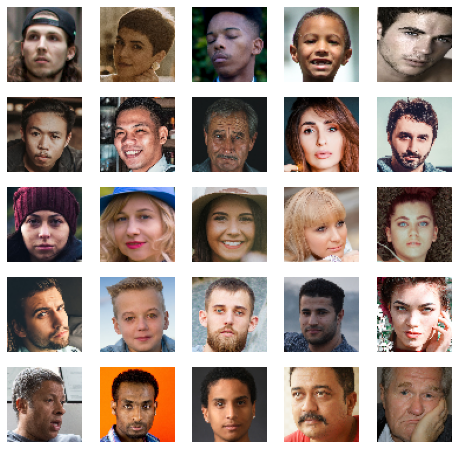

In [ ]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

# GAN Class:

In [ ]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0001,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    
    def build_generator(self):
        epsilon = 0.00001 
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))


        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            
            
            
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            
            for _ in range(2):
                noise = np.random.normal(0, 1, (batch_size, self.noise_size))

                valid_y = np.array([1] * batch_size)
                g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
           
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
           
            if epoch % save_images == 0:
                self.save_images(epoch)

            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

In [ ]:
!mkdir animeGenerated

# Training Phase:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                        

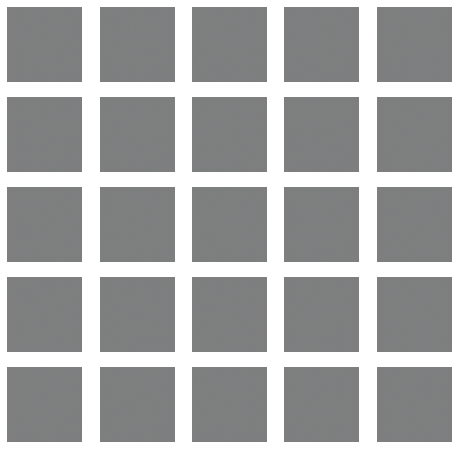

4/4 [==============================] - 0s 19ms/step
200 [Discriminator loss: 0.400825, acc.: 82.82%] [Generator loss: 1.694787]
4/4 [==============================] - 0s 19ms/step
400 [Discriminator loss: 0.459918, acc.: 78.70%] [Generator loss: 1.292353]
4/4 [==============================] - 0s 18ms/step
600 [Discriminator loss: 0.454217, acc.: 79.24%] [Generator loss: 1.406162]
4/4 [==============================] - 0s 19ms/step
800 [Discriminator loss: 0.352457, acc.: 84.72%] [Generator loss: 1.308554]
4/4 [==============================] - 0s 18ms/step
1000 [Discriminator loss: 0.449664, acc.: 79.13%] [Generator loss: 1.685543]
1/1 [==============================] - 0s 16ms/step


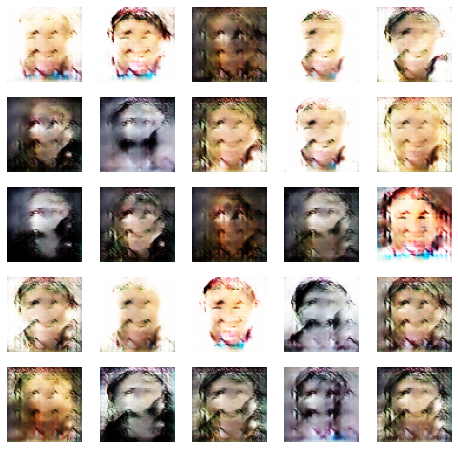

4/4 [==============================] - 0s 19ms/step
1200 [Discriminator loss: 0.423155, acc.: 80.25%] [Generator loss: 1.610409]
4/4 [==============================] - 0s 18ms/step
1400 [Discriminator loss: 0.441390, acc.: 79.16%] [Generator loss: 1.568703]
4/4 [==============================] - 0s 19ms/step
1600 [Discriminator loss: 0.393302, acc.: 81.80%] [Generator loss: 1.520943]
4/4 [==============================] - 0s 19ms/step
1800 [Discriminator loss: 0.304949, acc.: 86.99%] [Generator loss: 1.191692]
4/4 [==============================] - 0s 19ms/step
2000 [Discriminator loss: 0.397867, acc.: 82.07%] [Generator loss: 1.371902]
1/1 [==============================] - 0s 17ms/step


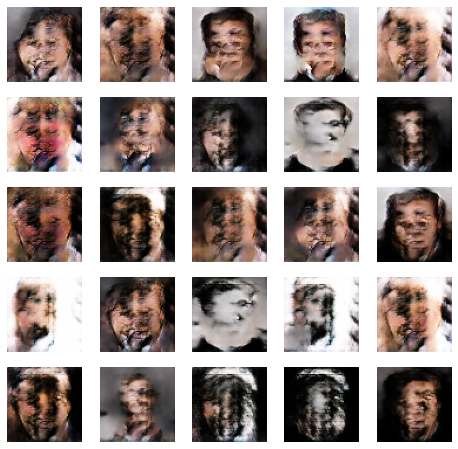

4/4 [==============================] - 0s 20ms/step
2200 [Discriminator loss: 0.390489, acc.: 82.33%] [Generator loss: 1.173786]
4/4 [==============================] - 0s 19ms/step
2400 [Discriminator loss: 0.354554, acc.: 84.32%] [Generator loss: 1.148883]
4/4 [==============================] - 0s 18ms/step
2600 [Discriminator loss: 0.414266, acc.: 81.26%] [Generator loss: 1.193423]
4/4 [==============================] - 0s 18ms/step
2800 [Discriminator loss: 0.362249, acc.: 83.54%] [Generator loss: 1.190841]
4/4 [==============================] - 0s 19ms/step
3000 [Discriminator loss: 0.361020, acc.: 84.47%] [Generator loss: 1.167219]
1/1 [==============================] - 0s 18ms/step


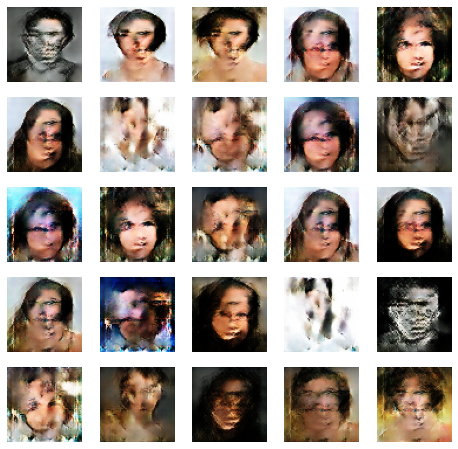

4/4 [==============================] - 0s 19ms/step
3200 [Discriminator loss: 0.374601, acc.: 83.04%] [Generator loss: 1.365233]
4/4 [==============================] - 0s 19ms/step
3400 [Discriminator loss: 0.392166, acc.: 82.44%] [Generator loss: 1.382453]
4/4 [==============================] - 0s 18ms/step
3600 [Discriminator loss: 0.364901, acc.: 83.84%] [Generator loss: 1.453756]
4/4 [==============================] - 0s 19ms/step
3800 [Discriminator loss: 0.399768, acc.: 81.82%] [Generator loss: 1.462373]
4/4 [==============================] - 0s 18ms/step
4000 [Discriminator loss: 0.370386, acc.: 83.33%] [Generator loss: 1.340021]
1/1 [==============================] - 0s 16ms/step


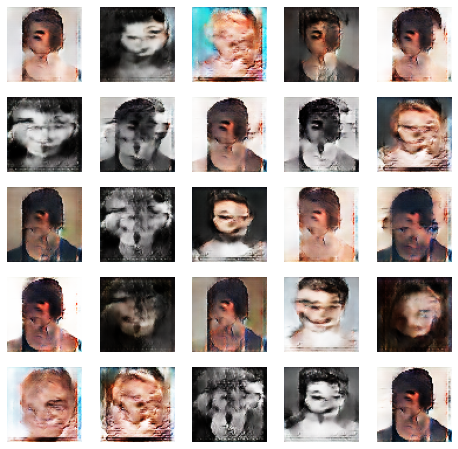

4/4 [==============================] - 0s 18ms/step
4200 [Discriminator loss: 0.394984, acc.: 82.04%] [Generator loss: 1.445425]
4/4 [==============================] - 0s 19ms/step
4400 [Discriminator loss: 0.385579, acc.: 82.45%] [Generator loss: 1.770078]
4/4 [==============================] - 0s 19ms/step
4600 [Discriminator loss: 0.359288, acc.: 83.88%] [Generator loss: 1.682291]
4/4 [==============================] - 0s 19ms/step
4800 [Discriminator loss: 0.361997, acc.: 84.25%] [Generator loss: 1.588239]
4/4 [==============================] - 0s 19ms/step
5000 [Discriminator loss: 0.369853, acc.: 83.50%] [Generator loss: 1.776991]
1/1 [==============================] - 0s 16ms/step


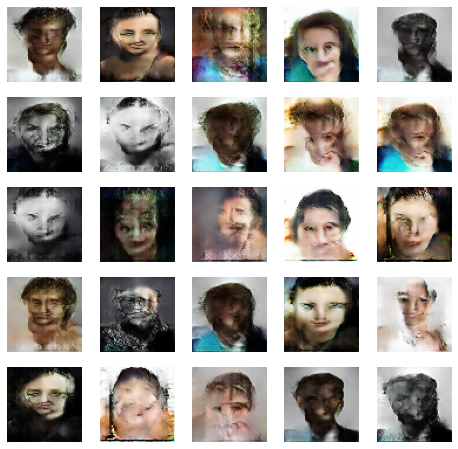

4/4 [==============================] - 0s 18ms/step
5200 [Discriminator loss: 0.349307, acc.: 84.62%] [Generator loss: 1.680895]
4/4 [==============================] - 0s 19ms/step
5400 [Discriminator loss: 0.348553, acc.: 84.63%] [Generator loss: 2.023789]
4/4 [==============================] - 0s 19ms/step
5600 [Discriminator loss: 0.322864, acc.: 86.23%] [Generator loss: 2.237192]
4/4 [==============================] - 0s 18ms/step
5800 [Discriminator loss: 0.304159, acc.: 87.21%] [Generator loss: 2.099350]
4/4 [==============================] - 0s 19ms/step
6000 [Discriminator loss: 0.280285, acc.: 88.30%] [Generator loss: 2.218926]
1/1 [==============================] - 0s 17ms/step


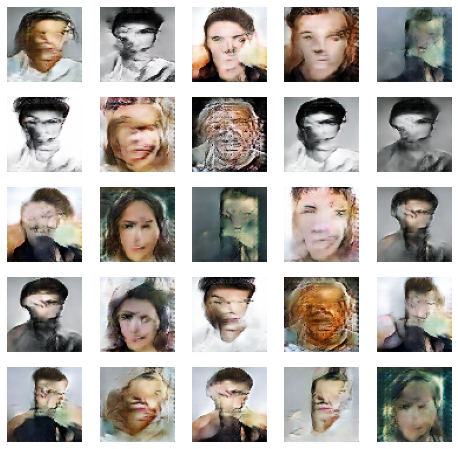

4/4 [==============================] - 0s 18ms/step
6200 [Discriminator loss: 0.265990, acc.: 89.08%] [Generator loss: 2.109270]
4/4 [==============================] - 0s 19ms/step
6400 [Discriminator loss: 0.275576, acc.: 88.55%] [Generator loss: 2.479939]
4/4 [==============================] - 0s 19ms/step
6600 [Discriminator loss: 0.277540, acc.: 88.34%] [Generator loss: 2.632056]
4/4 [==============================] - 0s 18ms/step
6800 [Discriminator loss: 0.275990, acc.: 88.35%] [Generator loss: 2.626415]
4/4 [==============================] - 0s 18ms/step
7000 [Discriminator loss: 0.256160, acc.: 89.52%] [Generator loss: 2.742515]
1/1 [==============================] - 0s 16ms/step


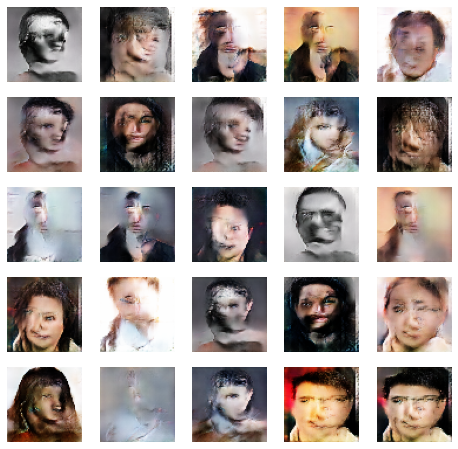

4/4 [==============================] - 0s 19ms/step
7200 [Discriminator loss: 0.225007, acc.: 90.96%] [Generator loss: 2.868948]
4/4 [==============================] - 0s 19ms/step
7400 [Discriminator loss: 0.225456, acc.: 90.93%] [Generator loss: 2.963887]
4/4 [==============================] - 0s 19ms/step
7600 [Discriminator loss: 0.222171, acc.: 91.07%] [Generator loss: 3.057420]
4/4 [==============================] - 0s 19ms/step
7800 [Discriminator loss: 0.202541, acc.: 91.93%] [Generator loss: 3.254346]
4/4 [==============================] - 0s 18ms/step
8000 [Discriminator loss: 0.200456, acc.: 92.06%] [Generator loss: 3.524072]
1/1 [==============================] - 0s 15ms/step


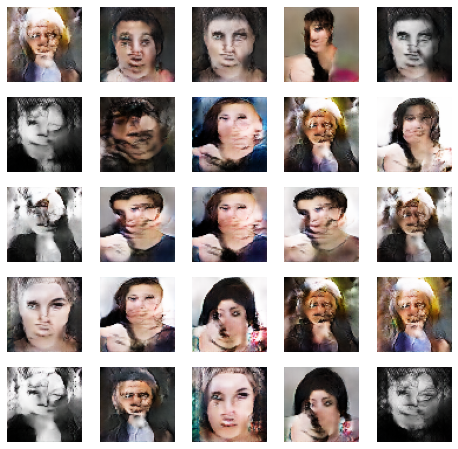

In [ ]:
gan=GAN()
gan.train(epochs=8001, batch_size=256, metrics_update=200, save_images=1000, save_model=8000)

In [ ]:
print("This code snippet ran successfully!")

This code snippet ran successfully!
